In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import regdiffusion as rd
import scanpy as sc
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net

# BEELINE Benchmarks

In [15]:
all_results = []
# logs_dt = []
# for dt in ['hESC', 'hHep', 'mDC', 'mESC', 'mHSC-E', 'mHSC-GM', 'mHSC-L']:
for dt in ['hESC']:
    bl_data, bl_gt = rd.data.load_beeline(benchmark_data=dt, benchmark_setting='1000_STRING')
    evaluator = rd.GRNEvaluator(bl_gt, bl_data.var_names)

    trainer = rd.RegDiffusionTrainer(bl_data.X, evaluator=evaluator)
    trainer.train(1000)
    adj = trainer.get_adj()
    eval_result = evaluator.evaluate(adj)
    eval_result['dt'] = dt
    all_results.append(eval_result)
    logs = trainer.logger.to_df()
    logs['dt'] = dt
    # logs_dt.append(logs)

Training loss: 0.316, Change on Adj: -0.000: 100%|██████████| 1000/1000 [00:08<00:00, 121.04it/s]


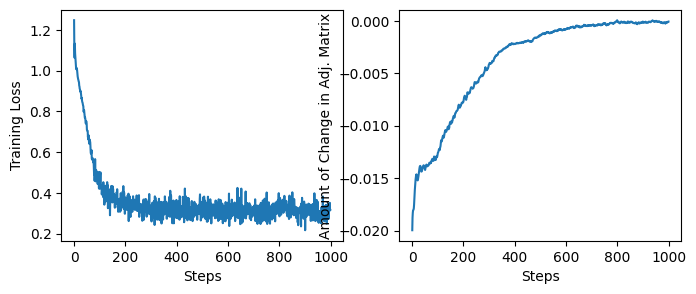

In [17]:
trainer.training_curves()

In [18]:
grn = trainer.generate_grn(bl_data.var_names)

In [21]:
bl_data.var_names

Index(['ZSWIM6', 'BAG3', 'GYPE', 'TRIM22', 'RBFOX2', 'UNG', 'FAM208A', 'RAE1',
       'ERCC-00096', 'SECISBP2L',
       ...
       'ATF6', 'EARS2', 'MXD4', 'GALC', 'CEBPZ', 'ROR2', 'CLDN11', 'TEAD1',
       'TRAPPC8', 'HAPLN1'],
      dtype='object', length=1410)

In [23]:
adj_table = grn.extract_node_2hop_neighborhood('BAG3')

In [24]:
adj_table.weight = adj_table.weight.map(lambda x: [1, 1, 0.2][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')

In [26]:
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [4]:
def read_hammond(time):
    ann_dt = sc.read_csv(
        f'../grnvae/data/other_data/Hammond_processed/final/male_{time}_data.csv'
    )
    
    ann_dt = ann_dt.transpose()
    
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Gm')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('mt')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rpl')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rps')]
    
    sc.pp.filter_genes(ann_dt, min_counts=0.00001)
    print(f'Hammond data at {time}: {ann_dt.shape}')
    
    return ann_dt

In [5]:
def read_cerebellum(selected_celltype):
    ann_dt = sc.read_h5ad(f'data/cerebellum/SCP795/processed/{selected_celltype}.h5ad')
    ann_dt = ann_dt.transpose()

    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Gm')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('mt')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rpl')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rps')]
    
    # subset_qc = sc.pp.calculate_qc_metrics(ann_dt)
    # # Here we only take roughly half of the genes (12,000). So we set the total 
    # # number of gene cutoff point at the median
    # total_gene_cutoff = subset_qc[1].total_counts.median()
    
    sc.pp.filter_genes(ann_dt, min_counts=0.0001)
    sc.pp.log1p(ann_dt)
    # print(f'Cerebellum data: {ann_dt.shape}; Cutoff at {total_gene_cutoff:.2f}')
    print(f'Cerebellum data: {ann_dt.shape}')

    return ann_dt

In [6]:
hammond_p100 = read_hammond('p100')

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Hammond data at p100: (8259, 14065)


In [7]:
trainer = rd.RegDiffusionTrainer(hammond_p100.X)
trainer.train()
logs = trainer.logger.to_df()
logs['dt'] = 'Hammond'


Training loss: 0.240, Change on Adj: -0.001: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


NameError: name 'logs_dt' is not defined

In [8]:
adj = trainer.model.get_adj()

In [10]:
adj.max() * trainer.n_gene

13.07565464900108

In [10]:
cc = read_cerebellum('Microglia')
trainer = rd.RegDiffusionTrainer(cc.X.toarray())
trainer.train()
logs = trainer.logger.to_df()
logs['dt'] = 'Atlas'
logs_dt.append(logs)

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Cerebellum data: (1296, 15547)


Training loss: 0.228, Change on Adj: -0.001: 100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]


In [11]:
pd.concat(logs_dt).to_csv('results/change_on_adj.csv', index=False)

In [15]:
bl_data, bl_gt = rd.data.load_beeline(benchmark_data='mESC', benchmark_setting='1000_STRING')
evaluator = rd.GRNEvaluator(bl_gt, bl_data.var_names)

trainer = rd.RegDiffusionTrainer(bl_data.X, train_split=0.8, eval_on_n_steps=1)
trainer.train(1000)
adj = trainer.get_adj()
eval_result = evaluator.evaluate(adj)

Training loss: 0.293, Change on Adj: -0.000: 100%|██████████| 1000/1000 [00:10<00:00, 99.11it/s]


In [17]:
trainer.logger.to_df().to_csv('results/mESC_train_test.csv', index=False)

In [20]:
hd_results = []
for hd in [8, 16, 32, 64, 128]:
    bl_data, bl_gt = rd.data.load_beeline(benchmark_data='mESC', benchmark_setting='1000_STRING')
    evaluator = rd.GRNEvaluator(bl_gt, bl_data.var_names)
    
    trainer = rd.RegDiffusionTrainer(bl_data.X, evaluator=evaluator, hidden_dims=[hd, hd, hd])
    trainer.train(1000)
    adj = trainer.get_adj()
    eval_result = evaluator.evaluate(adj)
    log = trainer.logger.to_df()
    log['hd'] = hd
    hd_results.append(log)

Training loss: 0.275, Change on Adj: 0.000: 100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


In [21]:
pd.concat(hd_results).to_csv('results/hidden_dim.csv', index=False)

In [22]:
import pickle

In [23]:
with open('results/202402/hammond.pkl', 'rb') as f:
    grn = pickle.load(f)

In [40]:
np.random.choice(hammond_p100.var_names)

'Adcy3'

In [57]:
gene = 'Hk2'
k = 20
hop1 = grn.extract_node_neighbors(gene, k=k)
hop1['weight'] = 0
hop1_genes = set()
for g in hop1.source:
    if g != gene:
        hop1_genes.add(g)
for g in hop1.target:
    if g != gene:
        hop1_genes.add(g)
hop2s = pd.concat([grn.extract_node_neighbors(g, k=k) for g in hop1_genes])
hop2s['weight'] = 1
hop2_genes = set()
for g in hop2s.source:
    if g != gene and g not in hop1_genes:
        hop2_genes.add(g)
for g in hop2s.target:
    if g != gene and g not in hop1_genes:
        hop2_genes.add(g)
hop3s = []
for g in hop2_genes:
    hop3 = grn.extract_node_neighbors(g, k=k)
    hop3 = hop3[hop3.source.isin(hop2_genes) & hop3.target.isin(hop2_genes) ]
    hop3s.append(hop3)
hop3s = pd.concat(hop3s)
hop3s['weight'] = 2
adj_table = pd.concat([hop1, hop2s, hop3s]).reset_index(drop=True)

In [58]:
adj_table.weight = adj_table.weight.map(lambda x: [1, 1, 0.2][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [82]:
g.save_graph('results/202402/hammond_apoe.html')
# grn.save('results/202402/hammond.pkl')

In [30]:
cc = read_cerebellum('Microglia')

Cerebellum data: (1296, 15547)


/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [90]:
trainer = rd.RegDiffusionTrainer(cc.X.toarray())
trainer.train()

Training loss: 0.209, Change on Adj: -0.0003: 100%|██████████| 1000/1000 [04:10<00:00,  3.98it/s]


In [91]:
grn = trainer.generate_grn(cc.var_names)
gene = 'Apoe'
k = 20
hop1 = grn.extract_node_neighbors(gene, k=k)
hop1['weight'] = 0
hop1_genes = set()
for g in hop1.source:
    if g != gene:
        hop1_genes.add(g)
for g in hop1.target:
    if g != gene:
        hop1_genes.add(g)
hop2s = pd.concat([grn.extract_node_neighbors(g, k=k) for g in hop1_genes])
hop2s['weight'] = 1
hop2_genes = set()
for g in hop2s.source:
    if g != gene and g not in hop1_genes:
        hop2_genes.add(g)
for g in hop2s.target:
    if g != gene and g not in hop1_genes:
        hop2_genes.add(g)
hop3s = []
for g in hop2_genes:
    hop3 = grn.extract_node_neighbors(g, k=k)
    hop3 = hop3[hop3.source.isin(hop2_genes) & hop3.target.isin(hop2_genes) ]
    hop3s.append(hop3)
hop3s = pd.concat(hop3s)
hop3s['weight'] = 2
adj_table = pd.concat([hop1, hop2s, hop3s]).reset_index(drop=True)
adj_table.weight = adj_table.weight.map(lambda x: [1, 1, 1, 2][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [86]:
g.save_graph('results/202402/cc_apoe.html')
grn.save('results/202402/cc.pkl')